# 0. Importing Necessary Packages

어떻게 했는 지 모르겠는데 base python 3.7.6에서 안되던거 일단 아래 명령어로 해결 _ Kernel Restart 하고 나서 shell 명령 안되는 거 해결

In [1]:
%set_env PATH=/root/anaconda3/bin:/root/anaconda3/condabin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/root/.fzf./bin

env: PATH=/root/anaconda3/bin:/root/anaconda3/condabin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/root/.fzf./bin


In [2]:
# Printing the information of Python, IPython, OS, and the generation date.
%load_ext version_information
%version_information
%matplotlib inline

In [3]:
# Printing the versions of packages
from importlib_metadata import version
for pkg in ['numpy', 'matplotlib', 'astropy', 'pandas']:
    print(pkg+": ver "+version(pkg))

numpy: ver 1.18.1
matplotlib: ver 3.1.3
astropy: ver 4.0
pandas: ver 1.0.1


In [4]:
# matplotlib backend
%matplotlib notebook

# importing necessary modules
import numpy as np
import glob, os
from matplotlib import pyplot as plt
from astropy.io import fits
import pandas as pd
from acstools import acszpt
from reproject import reproject_interp

In [5]:
colnames_cat = ['id', 'RA','Dec', 'x', 'y', 'fwhm', 
'area', 'stel', 'ell', 'theta', 'nf5sig', 'nfobs', 'f435w_mag', 'f435w_magerr',
'f435w_flux', 'f435w_fluxerr', 'f435w_fluxnJy', 'f435w_fluxnJyerr', 'f435w_sig', 'f606w_mag', 'f606w_magerr', 'f606w_flux', 
'f606w_fluxerr' , 'f606w_fluxnJy', 'f606w_fluxnJyerr', 'f606w_sig', 'f814w_mag', 'f814w_magerr', 'f814w_flux', 'f814w_fluxerr', 
'f814w_fluxnJy', 'f814w_fluxnJyerr' , 'f814w_sig' , 'f105w_mag', 'f105w_magerr', 'f105w_flux', 'f105w_fluxerr', 'f105w_fluxnJy', 
'f105w_fluxnJyerr', 'f105w_sig', 'f125w_mag', 'f125w_magerr', 'f125w_flux', 'f125w_fluxerr', 'f125w_fluxnJy', 'f125w_fluxnJyerr', 'f125w_sig', 
'f140w_mag', 'f140w_magerr', 'f140w_flux', 'f140w_fluxerr', 'f140w_fluxnJy', 'f140w_fluxnJyerr', 'f140w_sig', 'f160w_mag', 'f160w_magerr', 'f160w_flux',
'f160w_fluxerr', 'f160w_fluxnJy', 'f160w_fluxnJyerr', 'f160w_sig', 'bright_mag', 'bright_magerr', 'zb', 'zbmin', 'zbmax', 'tb', 'odds', 'chisq', 
'chisq2', 'M0', 'zml', 'tml'] 
colnames = ['x','y','num','mag_auto','merr_auto','mag_iso','merr_iso','mag_isocor', 'magerr_isocor','kron','backgr','ra','dec',
            'a','b','theta','mu0','flag','fwhm','flxrad','cl']

In [6]:
band = ["F105W", "F160W"]
band_catread = ["f105w", "f160w"]

In [7]:
dat_cat = np.genfromtxt('/data/jip/1st_TASK_Relics_SMACS/catalog/hlsp_relics_hst_wfc3ir_smacs0723-73_multi_v1_cat.txt', dtype=None, encoding='ascii', names=colnames_cat)
dat_0 = np.genfromtxt( '{}.cat'.format(band[0]), dtype=None, encoding='ascii', names=colnames)
dat_1 = np.genfromtxt('{}.cat'.format(band[1]), dtype=None, encoding='ascii', names=colnames)

# 0. Galactic Extinction in Magnitudes

## magnitude correction

In [8]:
A_lambda_one = 1.015
A_lambda_two = 0.470 
EBV = 0.1893
exec("Extmag_{} = A_lambda_one * EBV".format(band[0]))
exec("Extmag_{} = A_lambda_two * EBV".format(band[1]))
exec("dat_0['mag_isocor'] = dat_0['mag_isocor'] - Extmag_{}".format(band[0]))
exec("dat_1['mag_isocor'] = dat_1['mag_isocor'] - Extmag_{}".format(band[1]))

# 1. Raw-Data Plot

## 1) RA/dec

In [9]:
%matplotlib inline

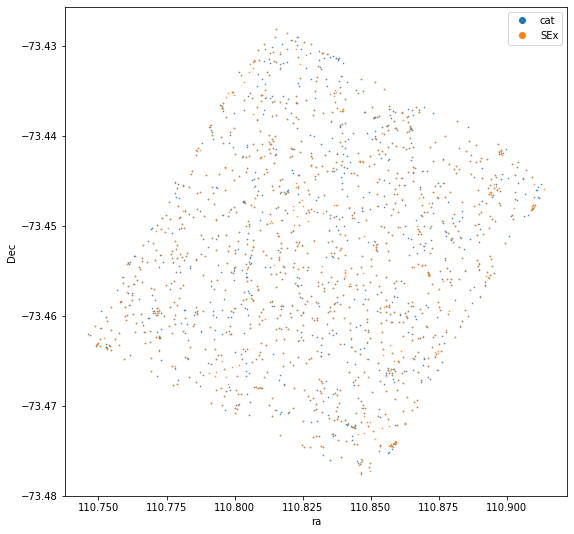

In [10]:
fig, axs = plt.subplots(1, 1, figsize=(9,9))
axs.plot(dat_cat['RA'], dat_cat['Dec'], 'o', ms = 0.5, label = 'cat')
axs.plot(dat_0['ra'], dat_0['dec'], 'o', ms=0.5, label = 'SEx')
axs.set_xlabel("ra")
axs.set_ylabel("Dec")
# change legend markersize
lgnd = axs.legend()
lgnd.legendHandles[0]._legmarker.set_markersize(6)
lgnd.legendHandles[1]._legmarker.set_markersize(6)

## 2) Mag-Magerr Plot

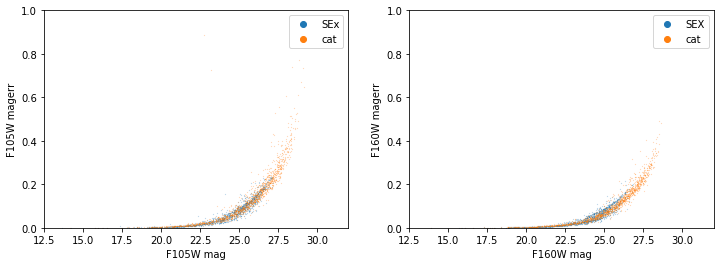

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))
mag_range = (dat_0['mag_isocor'] < 99.0)&(dat_1['mag_isocor']<99.0)
# magnitude of 99.0 means the source not detected in the 606-band image but detected in the 814-band image.
ax[0].plot(dat_0['mag_isocor'][mag_range], dat_0['magerr_isocor'][mag_range], 'o', ms=0.1, label='SEx')
ax[0].plot(dat_cat['{}_mag'.format(band_catread[0])], dat_cat['{}_magerr'.format(band_catread[0])], 'o', ms=0.1, label='cat')
ax[0].set_xlim([12.5, 32])
ax[0].set_ylim([0.0, 1.0])
ax[0].set_xlabel('{} mag'.format(band[0]))
ax[0].set_ylabel('{} magerr'.format(band[0]))


ax[1].plot(dat_1['mag_isocor'][mag_range], dat_1['magerr_isocor'][mag_range], 'o', ms=0.1, label='SEX')
ax[1].plot(dat_cat['{}_mag'.format(band_catread[1])], dat_cat['{}_magerr'.format(band_catread[1])], 'o', ms=0.1, label='cat')
ax[1].set_xlim([12.5, 32])
ax[1].set_ylim([0, 1])
ax[1].set_xlabel('{} mag'.format(band[1]))
ax[1].set_ylabel('{} magerr'.format(band[1]))

#=================================================================
lgnd0 = ax[0].legend()
lgnd0.legendHandles[0]._legmarker.set_markersize(6)
lgnd0.legendHandles[1]._legmarker.set_markersize(6)
lgnd1 = ax[1].legend()
lgnd1.legendHandles[0]._legmarker.set_markersize(6)
lgnd1.legendHandles[1]._legmarker.set_markersize(6)

## 3) Magnitude - stellarity (``CLASS_STAR``) digram

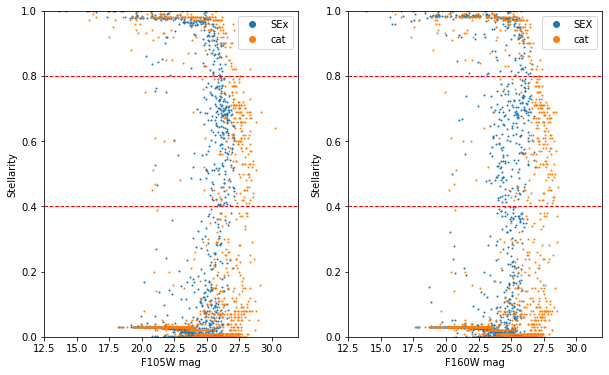

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(10,6))
mag_range = (dat_0['mag_isocor'] < 99.0)&(dat_1['mag_isocor']<99.0)
# magnitude of 99.0 means the source not detected in the 606-band image but detected in the 814-band image.
ax[0].plot(dat_0['mag_isocor'][mag_range], dat_0['cl'][mag_range], 'o', ms=1, label='SEx')
ax[0].plot(dat_cat['{}_mag'.format(band_catread[0])], dat_cat['stel'], 'o', ms=1, label='cat')
ax[0].set_xlim([12.5, 32])
ax[0].set_ylim([0.0, 1.0])
ax[0].set_xlabel('{} mag'.format(band[0]))
ax[0].set_ylabel('Stellarity')
ax[0].axhline(0.4, 0, 1, color='red', ls='--', lw=1)
ax[0].axhline(0.8, 0, 1, color='red', ls='--', lw=1)


ax[1].plot(dat_1['mag_isocor'][mag_range], dat_1['cl'][mag_range], 'o', ms=1, label='SEX')
ax[1].plot(dat_cat['{}_mag'.format(band_catread[1])], dat_cat['stel'], 'o', ms=1, label='cat')
ax[1].set_xlim([12.5, 32])
ax[1].set_ylim([0, 1])
ax[1].set_xlabel('{} mag'.format(band[1]))
ax[1].set_ylabel('Stellarity')
ax[1].axhline(0.4, 0, 1, color='red', ls='--', lw=1)
ax[1].axhline(0.8, 0, 1, color='red', ls='--', lw=1)

#=================================================================
lgnd0 = ax[0].legend()
lgnd0.legendHandles[0]._legmarker.set_markersize(6)
lgnd0.legendHandles[1]._legmarker.set_markersize(6)
lgnd1 = ax[1].legend()
lgnd1.legendHandles[0]._legmarker.set_markersize(6)
lgnd1.legendHandles[1]._legmarker.set_markersize(6)

## 4) CMD

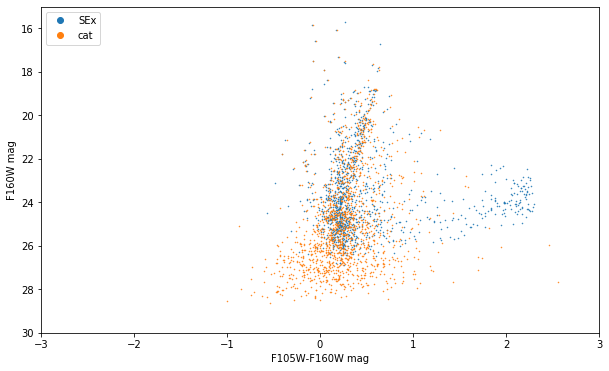

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
galcnd = (dat_0['mag_isocor'] < 99.0)&(dat_1['mag_isocor']<99.0) #&(dat_0['flxrad'] > 4.) & (dat_0['fwhm'] > 4.) & (dat_1['fwhm'] > 4.) & (dat_1['merr'] < 0.5) & (dat_0['merr'] < 0.5)&(dat_1['cl'] < 0.4)


# magnitude of 99.0 means the source not detected in the 606-band image but detected in the 814-band image.
ax.plot(dat_0['mag_isocor'][galcnd]-dat_1['mag_isocor'][galcnd], dat_1['mag_isocor'][galcnd], 'o', ms=0.5, label='SEx')
ax.plot(dat_cat['{}_mag'.format(band_catread[0])]-dat_cat['{}_mag'.format(band_catread[1])], dat_cat['{}_mag'.format(band_catread[1])], 'o', ms=0.5, label='cat')
ax.set_xlim([-3, 3])
ax.set_ylim([30, 15])
ax.set_xlabel('{}-{} mag'.format(band[0], band[1]))
ax.set_ylabel('{} mag'.format(band[1]))

#=================================================================
lgnd0 = ax.legend()
lgnd0.legendHandles[0]._legmarker.set_markersize(6)
lgnd0.legendHandles[1]._legmarker.set_markersize(6)

# 2. Catalog - Sextractor Matching

In [14]:
#%matplotlib notebook
from astropy import coordinates
from astropy.table import Table
class matching2:
    match_thres = 0.2 #0.5 였음 #~ FWHM/2  #FWHM = 0.2arcsec =  3.3pixel
    def __init__(self, coordr, coord):
        match_thresf = self.match_thres
        matchres = coordinates.match_coordinates_sky(coordr, coord,
                                            nthneighbor = 1, storekdtree = 'kdtree_sky')
        matchres = [matchres[0], matchres[1].arcsec, matchres[2].value]
        matchhead = ['idcatcoord', 'sep2d', 'dist3d']
        matcht = Table(rows = np.array(matchres).T, names = matchhead,
                       dtype = ('i8', 'f8', 'f8'))
        self.table = matcht
        self.indr = np.where(matcht['sep2d'] < match_thresf)[0]
        self.indt = np.array(matcht['idcatcoord'][np.where(matcht['sep2d'] < match_thresf)[0]])
        
    def catalogr(self, catr):
        return catr[self.indr]
        
    
    def catalogt(self, catt):
        return catt[self.indt]

In [15]:
from astropy.coordinates import SkyCoord
from astropy import units as u
ra1, dec1 = dat_0['ra'], dat_0['dec']
ra2, dec2 = dat_cat['RA'], dat_cat['Dec']
c = SkyCoord(ra=ra1*u.degree, dec=dec1*u.degree)  
catalog = SkyCoord(ra=ra2*u.degree, dec=dec2*u.degree)
a = matching2(c, catalog)

In [16]:
b11 = a.catalogr(c)
b12 = a.catalogt(catalog)

b11_ra = b11.ra
b11_dec = b11.dec
b12_ra = b12.ra
b12_dec = b12.dec

## 1) Plot of Matched Source and Detected Source

" # one-time \nfig, ax = plt.subplots(1, 1, figsize=(7, 7))\nax.plot(b11_ra, b11_dec, 'o', ms=1, label = 'SEx-matched')\nax.plot(b12_ra, b12_dec, 'o', ms=1, label = 'cat-matched')\nlgnd0 = ax.legend()\nlgnd0.legendHandles[0]._legmarker.set_markersize(6)\nlgnd0.legendHandles[1]._legmarker.set_markersize(6)\n"

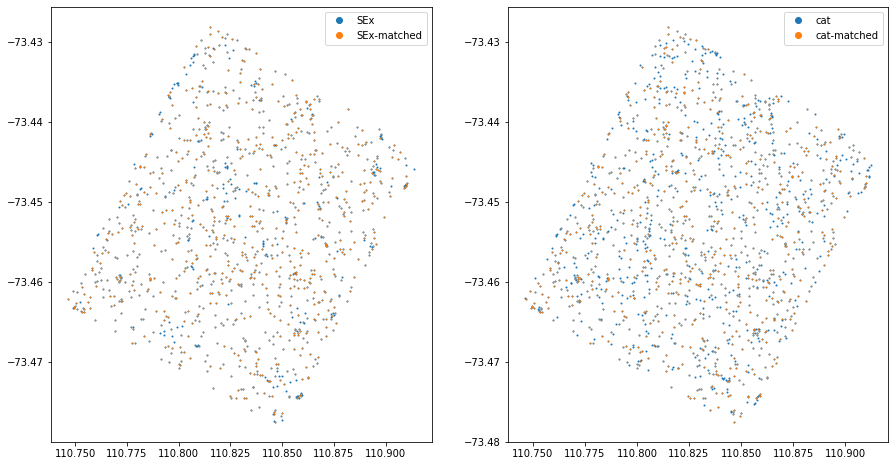

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(15,8))
ax[0].plot(dat_0['ra'], dat_0['dec'], 'o', ms=1, label = 'SEx')
ax[0].plot(b11_ra, b11_dec, 'o', ms=0.6, label = 'SEx-matched')
ax[1].plot(dat_cat['RA'], dat_cat['Dec'], 'o', ms=1, label='cat')
ax[1].plot(b12_ra, b12_dec, 'o', ms=0.6, label = 'cat-matched')
lgnd0 = ax[0].legend()
lgnd0.legendHandles[0]._legmarker.set_markersize(6)
lgnd0.legendHandles[1]._legmarker.set_markersize(6)

lgnd1 = ax[1].legend()
lgnd1.legendHandles[0]._legmarker.set_markersize(6)
lgnd1.legendHandles[1]._legmarker.set_markersize(6)


''' # one-time 
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ax.plot(b11_ra, b11_dec, 'o', ms=1, label = 'SEx-matched')
ax.plot(b12_ra, b12_dec, 'o', ms=1, label = 'cat-matched')
lgnd0 = ax.legend()
lgnd0.legendHandles[0]._legmarker.set_markersize(6)
lgnd0.legendHandles[1]._legmarker.set_markersize(6)
'''


Matching Catalog Index and Detected Index <br>
b11, b12는 각각 dat_0과 dat_cat의 매칭된 녀석들의 (ra/dec)정보를 담고 있는 array <br>
지금 밑코드는 매칭된 녀석들이 각각 원래 dat_0 dat_cat에서의 index를 알아보는 코드

In [18]:
ra1, dec1 = dat_0['ra'], dat_0['dec']
ra3, dec3 = np.array(b11_ra), np.array(b11_dec)
c = SkyCoord(ra=ra1*u.degree, dec=dec1*u.degree)
catalog = SkyCoord(ra=ra3*u.degree, dec=dec3*u.degree)
idx, d2d, d3d = c.match_to_catalog_sky(catalog)

#===========================================================
print(np.size(c))
print(np.size(catalog))
print(np.size(idx))
print(np.max(idx))
print("===============")
#===========================================================
new_frame = (idx, d2d, d3d)
new_frame = np.transpose(new_frame)
new_frame = pd.DataFrame(new_frame, columns=['idx', 'd2d', 'd3d'])
new_frame['original_rowindex'] = new_frame.index
add = pd.DataFrame(columns=['idx', 'd2d', 'd3d']) 
for i in range(np.size(new_frame)):
    dff = new_frame.loc[new_frame['idx']==i]
    dff = dff.loc[dff['d2d'] == np.min(dff['d2d'])]
    add = add.append(dff, ignore_index=True)
new_frame = add
new_frame['original_rowindex'] = new_frame['original_rowindex'].astype(int)
sexmatch = new_frame['original_rowindex'] # SExtractor Output에서 match된 녀석들의 Dataframe index 


#==========================================

ra2, dec2 = dat_cat['RA'], dat_cat['Dec']
ra4, dec4 = np.array(b12_ra), np.array(b12_dec)
c2 = SkyCoord(ra=ra2*u.degree, dec=dec2*u.degree)
catalog2 = SkyCoord(ra=ra4*u.degree, dec=dec4*u.degree)
idx2, d2d2, d3d2 = c2.match_to_catalog_sky(catalog2)

#==================
print(np.size(c2))
print(np.size(catalog2))
print(np.size(idx2))
print(np.max(idx2))

#==========================
new_frame2 = (idx2, d2d2, d3d2)
new_frame2 = np.transpose(new_frame2)
new_frame2 = pd.DataFrame(new_frame2, columns=['idx', 'd2d', 'd3d'])
new_frame2['original_rowindex'] = new_frame2.index
add2 = pd.DataFrame(columns=['idx', 'd2d', 'd3d']) 
for i in range(np.size(new_frame2)):
    dff2 = new_frame2.loc[new_frame2['idx']==i]
    dff2 = dff2.loc[dff2['d2d'] == np.min(dff2['d2d'])]
    add2 = add2.append(dff2, ignore_index=True)
new_frame2 = add2
new_frame2['original_rowindex'] = new_frame2['original_rowindex'].astype(int)
catmatch = new_frame2['original_rowindex']  # Catalog에서 match된 녀석들의 Dataframe index


1181
1004
1181
1003
1475
1004
1475
1003


In [19]:
np.size(sexmatch)-np.size(catmatch) #catmatch가 찾지 못해서 공백이 생겼을 때 catmatch의 크기가 작아지는데 그 자리에 blank data 넣는 코딩이 안되서 ... 제대로 처리 못해서 크기가 다르고 
# 그래서 cmd 비교 그래프를 그리는데 에러가 남 (공백이 생기면 그대로 뒷 순번도 밀려서 번호 리스팅 되어서) 그래서 catmatch가 sexmatch랑 크기 같게 찾은 상태 이용중
# 즉, matching reference 사이의 크기가 달라 상호호환이 안되는 것임 근데 그 matching 내부 계산 이런걸로 에러 뜨지는 않음 

2

In [20]:
print("b11 size : {} ||| b12size : {}".format(np.size(b11), np.size(b12)))
print("catalog size : {}".format(np.size(dat_cat)))
print("catalog matched size : {}".format(np.size(catmatch)))
print("sextractor ouput size : {}".format(np.size(dat_0)))
print("sextractor ouput matched size : {}".format(np.size(sexmatch)))

b11 size : 1004 ||| b12size : 1004
catalog size : 1475
catalog matched size : 1002
sextractor ouput size : 1181
sextractor ouput matched size : 1004


Now idx are indices into catalog that are the closest objects to each of the coordinates in c, d2d are the on-sky distances between them, and d3d are the 3-dimensional distances. Because coordinate objects support indexing, idx enables easy access to the matched set of coordinates in the catalog:



In [21]:
''' 
new_frame2 = (idx2, d2d2, d3d2)
new_frame2 = np.transpose(new_frame2)
new_frame2 = pd.DataFrame(new_frame2, columns=['idx', 'd2d', 'd3d'])
new_frame2['original_rowindex'] = new_frame2.index
add2 = pd.DataFrame(columns=['idx', 'd2d', 'd3d']) 
dff2 = new_frame2.loc[new_frame2['idx']==272]
dff2 = dff2.loc[dff2['d2d'] == np.min(dff2['d2d'])]
add2 = add2.append(dff2, ignore_index=True)
dff2
new_frame2.loc[new_frame2['idx']==274]
''' 

" \nnew_frame2 = (idx2, d2d2, d3d2)\nnew_frame2 = np.transpose(new_frame2)\nnew_frame2 = pd.DataFrame(new_frame2, columns=['idx', 'd2d', 'd3d'])\nnew_frame2['original_rowindex'] = new_frame2.index\nadd2 = pd.DataFrame(columns=['idx', 'd2d', 'd3d']) \ndff2 = new_frame2.loc[new_frame2['idx']==272]\ndff2 = dff2.loc[dff2['d2d'] == np.min(dff2['d2d'])]\nadd2 = add2.append(dff2, ignore_index=True)\ndff2\nnew_frame2.loc[new_frame2['idx']==274]\n"

## 2) Drawing Plot Again with Matching INDEX

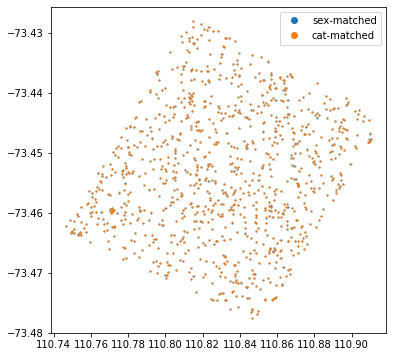

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(6,6))
# ax[0].plot(dat_0['ra'], dat_0['dec'], 'o', ms=1, label = 'SEx')
# ax[0].plot(b11_ra, b11_dec, 'o', ms=1, label = 'SEx-matched')
# ax[1].plot(b12_ra, b12_dec, 'o', ms=1, label = 'cat-matched')
ax.plot(dat_0['ra'][sexmatch], dat_0['dec'][sexmatch], 'o', ms=1, label='sex-matched')
ax.plot(dat_cat['RA'][catmatch], dat_cat['Dec'][catmatch], 'o', ms=1, label='cat-matched')

lgnd0 = ax.legend()
lgnd0.legendHandles[0]._legmarker.set_markersize(6)
lgnd0.legendHandles[1]._legmarker.set_markersize(6)

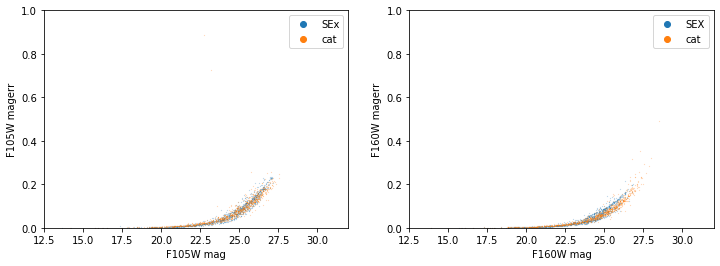

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))
# magnitude of 99.0 means the source not detected in the 606-band image but detected in the 814-band image.
ax[0].plot(dat_0['mag_isocor'][sexmatch], dat_0['magerr_isocor'][sexmatch], 'o', ms=0.1, label='SEx')
ax[0].plot(dat_cat['{}_mag'.format(band_catread[0])][catmatch], dat_cat['{}_magerr'.format(band_catread[0])][catmatch], 'o', ms=0.1, label='cat')
ax[0].set_xlim([12.5, 32])
ax[0].set_ylim([0.0, 1.0])
ax[0].set_xlabel('{} mag'.format(band[0]))
ax[0].set_ylabel('{} magerr'.format(band[0]))


ax[1].plot(dat_1['mag_isocor'][sexmatch], dat_1['magerr_isocor'][sexmatch], 'o', ms=0.1, label='SEX')
ax[1].plot(dat_cat['{}_mag'.format(band_catread[1])][catmatch], dat_cat['{}_magerr'.format(band_catread[1])][catmatch], 'o', ms=0.1, label='cat')
ax[1].set_xlim([12.5, 32])
ax[1].set_ylim([0, 1])
ax[1].set_xlabel('{} mag'.format(band[1]))
ax[1].set_ylabel('{} magerr'.format(band[1]))

#=================================================================
lgnd0 = ax[0].legend()
lgnd0.legendHandles[0]._legmarker.set_markersize(6)
lgnd0.legendHandles[1]._legmarker.set_markersize(6)
lgnd1 = ax[1].legend()
lgnd1.legendHandles[0]._legmarker.set_markersize(6)
lgnd1.legendHandles[1]._legmarker.set_markersize(6)

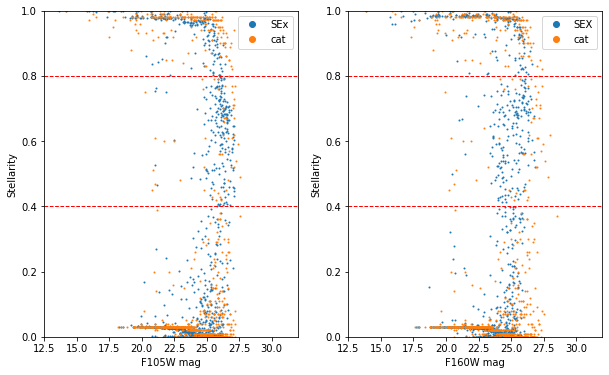

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(10,6))
# magnitude of 99.0 means the source not detected in the 606-band image but detected in the 814-band image.
ax[0].plot(dat_0['mag_isocor'][sexmatch], dat_0['cl'][sexmatch], 'o', ms=1, label='SEx')
ax[0].plot(dat_cat['{}_mag'.format(band_catread[0])][catmatch], dat_cat['stel'][catmatch], 'o', ms=1, label='cat')
ax[0].set_xlim([12.5, 32])
ax[0].set_ylim([0.0, 1.0])
ax[0].set_xlabel('{} mag'.format(band[0]))
ax[0].set_ylabel('Stellarity')
ax[0].axhline(0.4, 0, 1, color='red', ls='--', lw=1)
ax[0].axhline(0.8, 0, 1, color='red', ls='--', lw=1)


ax[1].plot(dat_1['mag_isocor'][sexmatch], dat_1['cl'][sexmatch], 'o', ms=1, label='SEX')
ax[1].plot(dat_cat['{}_mag'.format(band_catread[1])][catmatch], dat_cat['stel'][catmatch], 'o', ms=1, label='cat')
ax[1].set_xlim([12.5, 32])
ax[1].set_ylim([0, 1])
ax[1].set_xlabel('{} mag'.format(band[1]))
ax[1].set_ylabel('Stellarity')
ax[1].axhline(0.4, 0, 1, color='red', ls='--', lw=1)
ax[1].axhline(0.8, 0, 1, color='red', ls='--', lw=1)

#=================================================================
lgnd0 = ax[0].legend()
lgnd0.legendHandles[0]._legmarker.set_markersize(6)
lgnd0.legendHandles[1]._legmarker.set_markersize(6)
lgnd1 = ax[1].legend()
lgnd1.legendHandles[0]._legmarker.set_markersize(6)
lgnd1.legendHandles[1]._legmarker.set_markersize(6)

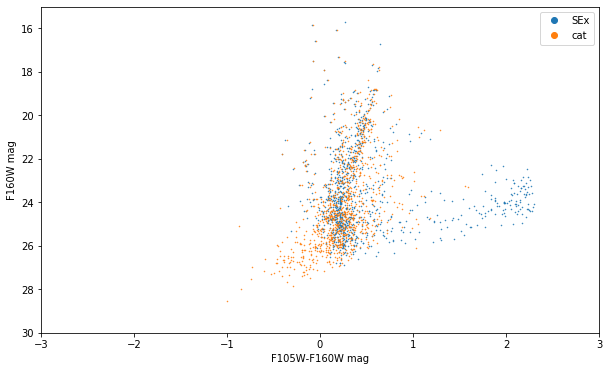

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
# galcnd = (dat_0['mag_isocor'] < 99.0)&(dat_1['mag_isocor']<99.0) #&(dat_0['flxrad'] > 4.) & (dat_0['fwhm'] > 4.) & (dat_1['fwhm'] > 4.) & (dat_1['merr'] < 0.5) & (dat_0['merr'] < 0.5)&(dat_1['cl'] < 0.4)


# magnitude of 99.0 means the source not detected in the 606-band image but detected in the 814-band image.
ax.plot(dat_0['mag_isocor'][sexmatch]-dat_1['mag_isocor'][sexmatch], dat_1['mag_isocor'][sexmatch], 'o', ms=0.5, label='SEx')
ax.plot(dat_cat['{}_mag'.format(band_catread[0])][catmatch]-dat_cat['{}_mag'.format(band_catread[1])][catmatch], dat_cat['{}_mag'.format(band_catread[1])][catmatch], 'o', ms=0.5, label='cat')
ax.set_xlim([-3, 3])
ax.set_ylim([30, 15])
ax.set_xlabel('{}-{} mag'.format(band[0],band[1]))
ax.set_ylabel('{} mag'.format(band[1]))

#=================================================================
lgnd0 = ax.legend()
lgnd0.legendHandles[0]._legmarker.set_markersize(6)
lgnd0.legendHandles[1]._legmarker.set_markersize(6)

CMD with Stellarity filter

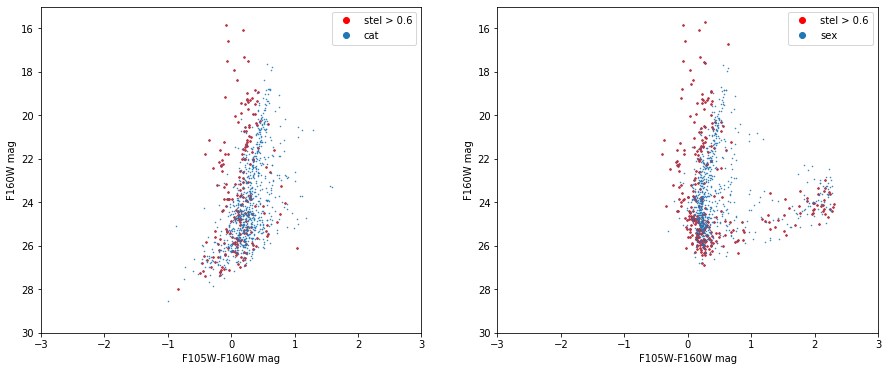

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(15,6))
# galcnd = (dat_0['mag_isocor'] < 99.0)&(dat_1['mag_isocor']<99.0) #&(dat_0['flxrad'] > 4.) & (dat_0['fwhm'] > 4.) & (dat_1['fwhm'] > 4.) & (dat_1['merr'] < 0.5) & (dat_0['merr'] < 0.5)&(dat_1['cl'] < 0.4)

a_Dat_cat = dat_cat['{}_mag'.format(band_catread[0])][catmatch]
b_Dat_cat = dat_cat['{}_mag'.format(band_catread[1])][catmatch]
a_Dat_sex = dat_0['mag_isocor'][sexmatch]
b_Dat_sex = dat_1['mag_isocor'][sexmatch]


stelf_cat = dat_cat[catmatch]['stel']>0.6
stelf_sex = dat_0[sexmatch]['cl']>0.6
# magnitude of 99.0 means the source not detected in the 606-band image but detected in the 814-band image.
ax[0].plot(a_Dat_cat[stelf_cat] - b_Dat_cat[stelf_cat], b_Dat_cat[stelf_cat], 'o', ms=1.5, color='red', label='stel > 0.6')
ax[0].plot(a_Dat_cat-b_Dat_cat, b_Dat_cat, 'o', ms=0.5, label='cat')

ax[1].plot(a_Dat_sex[stelf_sex] - b_Dat_sex[stelf_sex], b_Dat_sex[stelf_sex], 'o', ms=1.5, color='red', label='stel > 0.6')
ax[1].plot(a_Dat_sex-b_Dat_sex, b_Dat_sex, 'o', ms=0.5, label='sex')

ax[0].set_xlim([-3, 3])
ax[0].set_ylim([30, 15])
ax[0].set_xlabel('{}-{} mag'.format(band[0],band[1]))
ax[0].set_ylabel('{} mag'.format(band[1]))

ax[1].set_xlim([-3, 3])
ax[1].set_ylim([30, 15])
ax[1].set_xlabel('{}-{} mag'.format(band[0],band[1]))
ax[1].set_ylabel('{} mag'.format(band[1]))

#=================================================================
lgnd0 = ax[0].legend()
lgnd0.legendHandles[0]._legmarker.set_markersize(6)
lgnd0.legendHandles[1]._legmarker.set_markersize(6)
lgnd1 = ax[1].legend()
lgnd1.legendHandles[0]._legmarker.set_markersize(6)
lgnd1.legendHandles[1]._legmarker.set_markersize(6)

Outlier 특성 알아보기

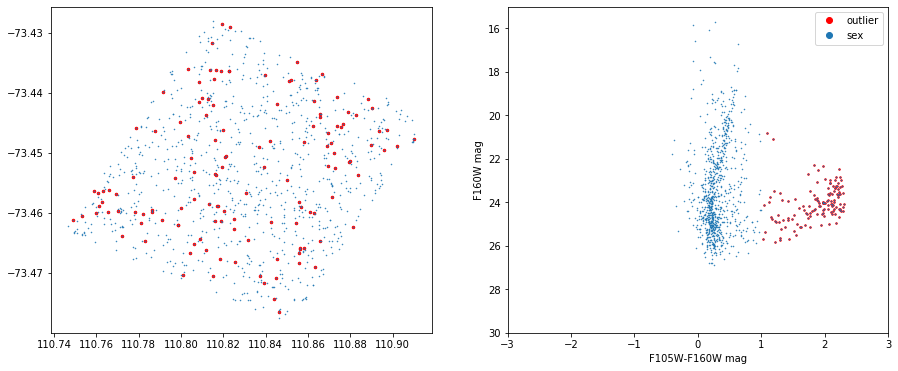

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(15,6))
# galcnd = (dat_0['mag_isocor'] < 99.0)&(dat_1['mag_isocor']<99.0) #&(dat_0['flxrad'] > 4.) & (dat_0['fwhm'] > 4.) & (dat_1['fwhm'] > 4.) & (dat_1['merr'] < 0.5) & (dat_0['merr'] < 0.5)&(dat_1['cl'] < 0.4)

a_Dat_cat = dat_cat['{}_mag'.format(band_catread[0])][catmatch]
b_Dat_cat = dat_cat['{}_mag'.format(band_catread[1])][catmatch]
a_Dat_sex = dat_0['mag_isocor'][sexmatch]
b_Dat_sex = dat_1['mag_isocor'][sexmatch]

a_Dat_sex2_ra = dat_0['ra'][sexmatch]
b_Dat_sex3_ra= dat_1['ra'][sexmatch]
a_Dat_sex2_dec = dat_0['dec'][sexmatch]
b_Dat_sex3_dec= dat_1['dec'][sexmatch]

stelf_sex = a_Dat_sex-b_Dat_sex > 1.0
# magnitude of 99.0 means the source not detected in the 606-band image but detected in the 814-band image.
# ax[0].plot(a_Dat_cat[stelf_cat] - b_Dat_cat[stelf_cat], b_Dat_cat[stelf_cat], 'o', ms=1.5, color='red', label='stel > 0.6')
ax[0].plot(a_Dat_sex2_ra[stelf_sex], a_Dat_sex2_dec[stelf_sex], 'o', ms=2.5, label='outlier', color='red')
ax[0].plot(a_Dat_sex2_ra, a_Dat_sex2_dec, 'o', ms=0.5, label='cat')

ax[1].plot(a_Dat_sex[stelf_sex] - b_Dat_sex[stelf_sex], b_Dat_sex[stelf_sex], 'o', ms=1.5, color='red', label='outlier')
ax[1].plot(a_Dat_sex-b_Dat_sex, b_Dat_sex, 'o', ms=0.5, label='sex')


ax[1].set_xlim([-3, 3])
ax[1].set_ylim([30, 15])
ax[1].set_xlabel('{}-{} mag'.format(band[0],band[1]))
ax[1].set_ylabel('{} mag'.format(band[1]))

#=================================================================

lgnd1 = ax[1].legend()
lgnd1.legendHandles[0]._legmarker.set_markersize(6)
lgnd1.legendHandles[1]._legmarker.set_markersize(6)

## 3) Error Estimation / Parameter Estimation

### (1) Matching Magnitude - Reference Magnitude Error --> thresh problem ? or zp? 


In [28]:
''' 
fig, ax = plt.subplots(1, 2, figsize=(12,4))
# magnitude of 99.0 means the source not detected in the 606-band image but detected in the 814-band image.
ax[0].plot(dat_0['mag_isocor'][sexmatch], dat_0['mag_isocor'][sexmatch]-dat_cat['f105w_mag'][catmatch], 'o', ms=1, label='f105w')
ax[0].set_xlim([12.5, 32])
ax[0].set_ylim([-1.5, 1.5])
ax[0].set_xlabel('sex mag')
ax[0].set_ylabel('sex mag - ref mag')
ax[0].axhline(0, ls='--', color='red')

ax[1].plot(dat_1['mag_isocor'][sexmatch], dat_1['mag_isocor'][sexmatch]-dat_cat['f160w_mag'][catmatch], 'o', ms=1, label='f160w')
ax[1].set_xlim([12.5, 32])
ax[1].set_ylim([-1.5, 1.5])
ax[1].set_xlabel('sex mag')
ax[1].set_ylabel('sex mag - ref mag')
ax[1].axhline(0, ls='--', color='red')

#=================================================================
lgnd0 = ax[0].legend()
lgnd0.legendHandles[0]._legmarker.set_markersize(6)
# lgnd0.legendHandles[1]._legmarker.set_markersize(6)
lgnd1 = ax[1].legend()
lgnd1.legendHandles[0]._legmarker.set_markersize(6)
# lgnd1.legendHandles[1]._legmarker.set_markersize(6)
''' 

" \nfig, ax = plt.subplots(1, 2, figsize=(12,4))\n# magnitude of 99.0 means the source not detected in the 606-band image but detected in the 814-band image.\nax[0].plot(dat_0['mag_isocor'][sexmatch], dat_0['mag_isocor'][sexmatch]-dat_cat['f105w_mag'][catmatch], 'o', ms=1, label='f105w')\nax[0].set_xlim([12.5, 32])\nax[0].set_ylim([-1.5, 1.5])\nax[0].set_xlabel('sex mag')\nax[0].set_ylabel('sex mag - ref mag')\nax[0].axhline(0, ls='--', color='red')\n\nax[1].plot(dat_1['mag_isocor'][sexmatch], dat_1['mag_isocor'][sexmatch]-dat_cat['f160w_mag'][catmatch], 'o', ms=1, label='f160w')\nax[1].set_xlim([12.5, 32])\nax[1].set_ylim([-1.5, 1.5])\nax[1].set_xlabel('sex mag')\nax[1].set_ylabel('sex mag - ref mag')\nax[1].axhline(0, ls='--', color='red')\n\n#=================================================================\nlgnd0 = ax[0].legend()\nlgnd0.legendHandles[0]._legmarker.set_markersize(6)\n# lgnd0.legendHandles[1]._legmarker.set_markersize(6)\nlgnd1 = ax[1].legend()\nlgnd1.legendHandles[0

### (2) FWHM Estimation 

In [29]:
# dat_cat = np.genfromtxt('../../../../../HST_SMACS/hst_smacs0723_catalog/hlsp_relics_hst_wfc3ir_smacs0723-73_multi_v1_cat.txt', dtype=None, encoding='ascii', names=colnames_cat)
# dat_0 = np.genfromtxt('../../../../../HST_SMACS/hst-reduced/img/analysis-result/F105W-F160W/F105W.cat', dtype=None, encoding='ascii', names=colnames)
# dat_1 = np.genfromtxt('../../../../../HST_SMACS/hst-reduced/img/analysis-result/F105W-F160W/F160W.cat', dtype=None, encoding='ascii', names=colnames)

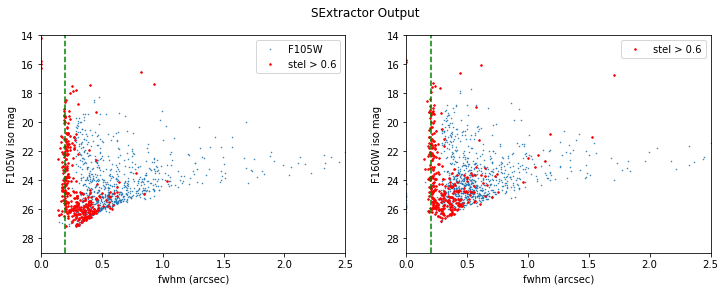

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))

pixel_scale = 0.06 #0.06arcsec/pixel

fig.suptitle('SExtractor Output')
pointsource1 = dat_0['cl']>0.6
ax[0].plot(dat_0['fwhm']*pixel_scale, dat_0['mag_isocor'], 'o', ms=0.5, label='{}'.format(band[0]))
ax[0].plot(dat_0['fwhm'][pointsource1]*pixel_scale, dat_0['mag_isocor'][pointsource1], 'o',color='red', ms=1.5, label='stel > 0.6')
ax[0].axvline(0.2, ls = '--', color='green')
ax[0].set_xlim([0, 2.5])
ax[0].set_ylim([29, 14])
ax[0].set_xlabel('fwhm (arcsec)')
ax[0].set_ylabel('{} iso mag'.format(band[0]))

pointsource2 = dat_1['cl']>0.6
ax[1].plot(dat_1['fwhm']*pixel_scale, dat_1['mag_isocor'], 'o', ms=0.5, label=''.format(band[1]))
ax[1].plot(dat_1['fwhm'][pointsource2]*pixel_scale, dat_1['mag_isocor'][pointsource2], 'o',color='red', ms=1.5, label='stel > 0.6')
ax[1].axvline(0.2, ls = '--', color='green')
ax[1].set_xlim([0, 2.5])
ax[1].set_ylim([29, 14])
ax[1].set_xlabel('fwhm (arcsec)')
ax[1].set_ylabel('{} iso mag'.format(band[1]))

lgnd0 = ax[0].legend()
lgnd1 = ax[1].legend()


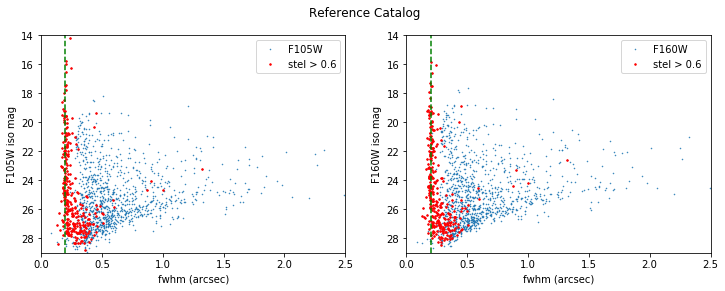

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))
fig.suptitle('Reference Catalog')
pointsource1 = dat_cat['stel']>0.6
ax[0].plot(dat_cat['fwhm'], dat_cat['{}_mag'.format(band_catread[0])], 'o', ms=0.5, label='{}'.format(band[0]))
ax[0].plot(dat_cat['fwhm'][pointsource1], dat_cat['{}_mag'.format(band_catread[0])][pointsource1], 'o',color='red', ms=1.5, label='stel > 0.6')
ax[0].axvline(0.2, ls = '--', color='green') #SExtractor 에서는 3pixel ~ 0.09 arcsec사용 
ax[0].set_xlim([0, 2.5])
ax[0].set_ylim([29, 14])
ax[0].set_xlabel('fwhm (arcsec)')
ax[0].set_ylabel('{} iso mag'.format(band[0]))

pointsource2 = dat_cat['stel']>0.6
ax[1].plot(dat_cat['fwhm'], dat_cat['{}_mag'.format(band_catread[1])], 'o', ms=0.5, label='{}'.format(band[1]))
ax[1].plot(dat_cat['fwhm'][pointsource2], dat_cat['{}_mag'.format(band_catread[1])][pointsource2], 'o',color='red', ms=1.5, label='stel > 0.6')
ax[1].axvline(0.2, ls = '--', color='green') #SExtractor 에서는 3pixel ~ 0.09 arcsec사용 
ax[1].set_xlim([0, 2.5])
ax[1].set_ylim([29, 14])
ax[1].set_xlabel('fwhm (arcsec)')
ax[1].set_ylabel('{} iso mag'.format(band[1]))

lgnd0 = ax[0].legend()
lgnd1 = ax[1].legend()


### (3) RA/DEC difference btw catalog and SExtractor ouput

In [32]:
''' 
fig, ax = plt.subplots(2, 2, figsize=(18,6))
ax[0,0].hist(dat_0['ra'][sexmatch]-dat_cat['RA'][catmatch], bins=10)
ax[0,1].hist(dat_1['ra'][sexmatch]-dat_cat['RA'][catmatch], bins=10)
ax[1,0].hist(dat_0['dec'][sexmatch]-dat_cat['Dec'][catmatch], bins=10)
ax[1,1].hist(dat_1['dec'][sexmatch]-dat_cat['Dec'][catmatch], bins=10)
''' 

" \nfig, ax = plt.subplots(2, 2, figsize=(18,6))\nax[0,0].hist(dat_0['ra'][sexmatch]-dat_cat['RA'][catmatch], bins=10)\nax[0,1].hist(dat_1['ra'][sexmatch]-dat_cat['RA'][catmatch], bins=10)\nax[1,0].hist(dat_0['dec'][sexmatch]-dat_cat['Dec'][catmatch], bins=10)\nax[1,1].hist(dat_1['dec'][sexmatch]-dat_cat['Dec'][catmatch], bins=10)\n"

전부 0 또는 0과 비슷한 매우 비슷한 상수 중심의 narrowband에 정규분포인 것처럼 보이나..  dec은 종모양이 안나옴 문제가 있음 --> 이것도 pixel scale, 이랑 논문 input 값 비교 수정 후 개선


Catalog_unmatched 된 친구들의 특성

In [33]:
notcatmatch = [] 

for i in range(np.size(dat_cat)):
    if i not in catmatch:
        notcatmatch.append(i)
dat_cat_unmatched = dat_cat[notcatmatch]
dat_cat_matched = dat_cat[catmatch]

print(np.size(dat_cat_unmatched))
print(np.size(dat_cat_matched))
print(np.size(dat_cat))



473
1002
1475


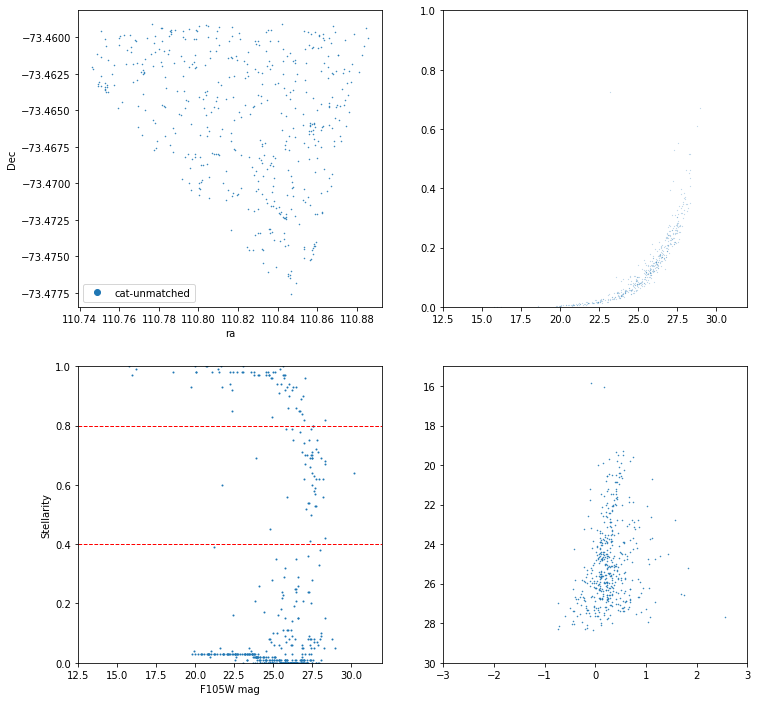

In [34]:
fig, ax = plt.subplots(2, 2, figsize=(12,12))
ax[0,0].plot(dat_cat_unmatched['RA'], dat_cat_unmatched['Dec'], 'o', ms = 0.5, label = 'cat-unmatched')
ax[0,0].set_xlabel("ra")
ax[0,0].set_ylabel("Dec")

ax[0,1].plot(dat_cat_unmatched['{}_mag'.format(band_catread[0])], dat_cat_unmatched['{}_magerr'.format(band_catread[0])], 'o', ms=0.1, label='SEx')
ax[0,1].set_xlim(12.5, 32)
ax[0,1].set_ylim(0, 1)

ax[1,0].plot(dat_cat_unmatched['{}_mag'.format(band_catread[0])], dat_cat_unmatched['stel'], 'o', ms=1, label='cat')
ax[1,0].set_xlim([12.5, 32])
ax[1,0].set_ylim([0.0, 1.0])
ax[1,0].set_xlabel('{} mag'.format(band[0]))
ax[1,0].set_ylabel('Stellarity')
ax[1,0].axhline(0.4, 0, 1, color='red', ls='--', lw=1)
ax[1,0].axhline(0.8, 0, 1, color='red', ls='--', lw=1)

ax[1,1].plot(dat_cat_unmatched['{}_mag'.format(band_catread[0])]-dat_cat_unmatched['{}_mag'.format(band_catread[1])], dat_cat_unmatched['{}_mag'.format(band_catread[1])], 'o', ms=0.5, label='cat')
ax[1,1].set_xlim([-3, 3])
ax[1,1].set_ylim([30, 15])
# change legend markersize
lgnd = ax[0,0].legend()
lgnd.legendHandles[0]._legmarker.set_markersize(6)
# lgnd.legendHandles[1]._legmarker.set_markersize(6)

Text(0, 0.5, 'Dec')

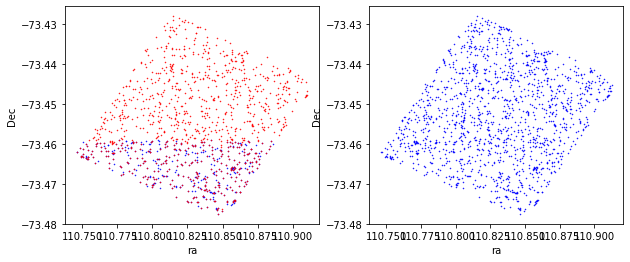

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].plot(dat_cat_unmatched['RA'], dat_cat_unmatched['Dec'], 'o', ms = 0.5, label = 'cat-unmatched', color = 'blue')
ax[0].set_xlabel("ra")
ax[0].set_ylabel("Dec")

ax[0].plot(dat_cat_matched['RA'], dat_cat_matched['Dec'], 'o', ms = 0.5, label = 'cat-matched', color = 'red')
ax[0].set_xlabel("ra")
ax[0].set_ylabel("Dec")

ax[1].plot(dat_cat['RA'], dat_cat['Dec'], 'o', ms = 0.5, label = 'cat-unmatched', color = 'blue')
ax[1].set_xlabel("ra")
ax[1].set_ylabel("Dec")


# lgnd.legendHandles[1]._legmarker.set_markersize(6)

match / unmatched 는 제기능을 수행하는데 unmatched 를 어떻게 detect 할 수 있을까 ? 